# MS016 Preprocess
06/14/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [35]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS016'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [36]:
edf_files = glob(f'{neural_dir}/MS016/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [37]:
mne_data

<RawEDF | MS016_SWB.edf, 276 x 2351040 (2295.9 s), ~4.83 GB, data loaded>

In [38]:
mne_data.ch_names

['LmOIF1',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LAgIT10',
 'LAgIT11',
 'LAgIT12',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LILS21',
 'LILS22',
 'LILS23',
 'LILS24',
 'LILS25',
 'LILS26',
 'LmLS31',
 'LmLS32',
 'LmLS33',
 'LmLS34',
 'LmLS35',
 'LmLS36',
 'LmLS37',
 'LmLS38',
 'C58',
 'C59',
 'C60',
 'C61',
 'C62',
 'C63',
 'C64',
 'LILS11',
 'LILS12',
 'LILS13',
 'LILS14',
 'LILS15',
 'LILS16',
 'LILS17',
 'LILS18',
 'RAgIT1',
 'RAgIT2',
 'RAgIT3',
 'RAgIT4',
 'RAgIT5',
 'RAgIT6',
 'RAgIT7',
 'RAgIT8',
 'RAgIT9',
 'RHpIT1',
 'RHpIT2',
 'RHpIT3',
 'RHpIT4',
 'RHpIT5',
 'RHpIT6',
 'RHpIT7',
 'RHpIT8',
 'RHpIT9',
 'RHpIT10',
 'RaCaS1',
 

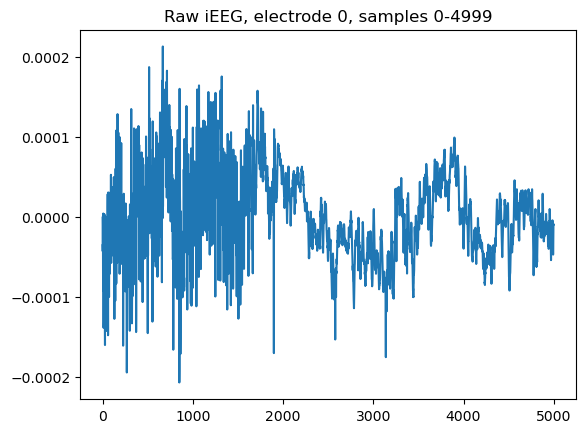

In [39]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

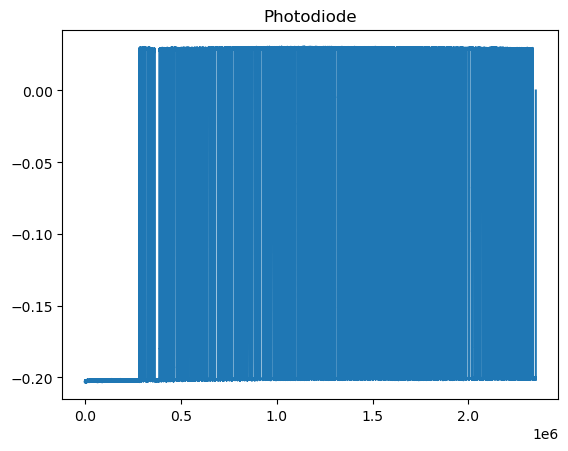

In [40]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [41]:
# Load the electrode localization data
ms016_anat_file = glob(f'{anat_dir}/MS016_labels.csv')[0]
elec_locs = pd.read_csv(ms016_anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCas1,A32sg_L,-4.195963,38.755833,1.548926,-4.923962,30.522125,-7.317985,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCas2,A24rv_L,-6.593655,39.555832,5.546539,-7.498945,32.166524,-2.505895,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,WM,NaN
2,LaCas3,Unknown,-8.991346,40.755832,9.544152,-10.170427,34.069446,2.265049,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
3,LaCas4,Unknown,-11.389038,41.955831,13.941527,-12.808619,36.020665,7.462891,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
4,LaCas5,Unknown,-13.786730,43.155830,17.939140,-15.421547,37.883783,12.121384,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,llem14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
150,llem15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
151,llem16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
152,llem17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN


In [42]:
list(elec_locs.label)

['LaCas1',
 'LaCas2',
 'LaCas3',
 'LaCas4',
 'LaCas5',
 'LaCas6',
 'LaCas7',
 'LaCas8',
 'LaCas9',
 'LaCas10',
 'LaCas11',
 'LaCas12',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LAgIT10',
 'LAgIT11',
 'LAgIT12',
 'LaImM1',
 'LaImM2',
 'LaImM3',
 'LaImM4',
 'LaImM5',
 'LaImM6',
 'LaImM7',
 'LaImM8',
 'LaImM9',
 'LaImM10',
 'LaImM11',
 'LaImM12',
 'LaImM13',
 'LaImM14',
 'LaImM15',
 'LaImM16',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LILS1_1',
 'LILS1_2',
 'LILS1_3',
 'LILS1_4',
 'LILS1_5',
 'LILS1_6',
 'LILS1_7',
 'LILS1_8',
 'LILS2_1',
 'LILS2_2',
 'LILS2_3',
 'LILS2_4',
 'LILS2_5',
 'LILS2_6',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LMLS3_1',
 'LMLS3_2',
 'LMLS3_3',
 'LMLS3_4',
 'LMLS3_5',
 'LMLS3_6',
 'LMLS3_7',
 'LMLS3_8',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOl

In [43]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [44]:
unmatched_names

['ulmolf', 'uragit']

In [45]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [46]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [47]:
new_name_dict

{'LmOIF1': 'lmolf1',
 'LmOIF2': 'lmolf2',
 'LmOIF3': 'lmolf3',
 'LmOIF4': 'lmolf4',
 'LmOIF5': 'lmolf5',
 'LmOIF6': 'lmolf6',
 'LmOIF7': 'lmolf7',
 'LmOIF8': 'lmolf8',
 'LmOIF9': 'lmolf9',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'LAgIT1': 'lagit1',
 'LAgIT2': 'lagit2',
 'LAgIT3': 'lagit3',
 'LAgIT4': 'lagit4',
 'LAgIT5': 'lagit5',
 'LAgIT6': 'lagit6',
 'LAgIT7': 'lagit7',
 'LAgIT8': 'lagit8',
 'LAgIT9': 'lagit9',
 'LAgIT10': 'lagit10',
 'LAgIT11': 'lagit11',
 'LAgIT12': 'lagit12',
 'LHpIT1': 'lhpit1',
 'LHpIT2': 'lhpit2',
 'LHpIT3': 'lhpit3',
 'LHpIT4': 'lhpit4',
 'LHpIT5': 'lhpit5',
 'LHpIT6': 'lhpit6',
 'LHpIT7': 'lhpit7',
 'LHpIT8': 'lhpit8',
 'LHpIT9': 'lhpit9',
 'LHpIT10': 'lhpit10',
 'LILS21': 'lils2_1',
 'LILS22': 'lils2_2',
 'LILS23': 'lils2_3',
 'LILS24': 'lils2

In [48]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS016_SWB.edf, 276 x 2351040 (2295.9 s), ~4.83 GB, data loaded>

In [49]:
unmatched_seeg

[]

In [50]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'c139', 'c140', 'c141', 'c142', 'c143', 'c144', 'c151', 'c152', 'c153', 'c154', 'c155', 'c156', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'chest1', 'chest2', 'abs1', 'abs2', 'c190', 'c191', 'c192', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [51]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 121 left & 31 right sEEG electrodes
We have a total of 152 sEEG electrodes


In [52]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['c126',
 'fp1',
 'c247',
 'c249',
 'dc13',
 't3',
 'c60',
 'c128',
 'c214',
 'c144',
 'dc5',
 'c59',
 'c155',
 'c215',
 'c244',
 'dc9',
 'c143',
 'chest2',
 'c217',
 'c253',
 'c122',
 'dc8',
 'c154',
 'c125',
 'dc11',
 'p3',
 'dc2',
 'c243',
 'ekg2',
 'dc15',
 'c216',
 'c213',
 'c234',
 'c64',
 'c246',
 'abs2',
 'pz',
 'dc10',
 'c120',
 'c218',
 'c141',
 'f7',
 'pr',
 'c4',
 'c248',
 'c211',
 'c222',
 'c252',
 'c212',
 'f3',
 'c192',
 'abs1',
 'dc6',
 'c255',
 'c245',
 'c123',
 'c140',
 'c61',
 'c224',
 'o2',
 'c121',
 'c236',
 'dc14',
 'c254',
 'c231',
 'fp2',
 'c190',
 'c191',
 'c124',
 'c237',
 'c242',
 'c142',
 'c62',
 'c250',
 'c240',
 'p4',
 't5',
 'c239',
 'c241',
 'c233',
 'c228',
 'f4',
 'c3',
 'c219',
 'c223',
 'dc16',
 'c63',
 'c210',
 'o1',
 't4',
 'c153',
 'f8',
 'chest1',
 'c139',
 'ekg1',
 'dc7',
 'pleth',
 'c220',
 'dc3',
 'c58',
 'dc4',
 'c156',
 'c229',
 'c127',
 'c225',
 'c221',
 'c232',
 'c227',
 'c230',
 'cz',
 'c256',
 'c226',
 'trig',
 'c209',
 't6',
 'c152',
 '

In [53]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS016_SWB.edf, 153 x 2351040 (2295.9 s), ~2.68 GB, data loaded>

In [54]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #'stim test1-ref' 'Stim TEST1-REF' stim stands for stimulus 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS016_SWB.edf, 153 x 2351040 (2295.9 s), ~2.68 GB, data loaded>

In [55]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS016_SWB.edf, 153 x 2351040 (2295.9 s), ~2.68 GB, data loaded>

### Notch filter line noise

In [56]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:    8.0s finished


<RawEDF | MS016_SWB.edf, 153 x 2351040 (2295.9 s), ~2.68 GB, data loaded>

### Resampling Data

In [57]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:   10.7s finished


<RawEDF | MS016_SWB.edf, 153 x 1175520 (2295.9 s), ~1.34 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [58]:
mne_data.save(f'{neural_dir}/MS016/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [59]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

In [60]:
bads

['lacas12',
 'lacas7',
 'laimm15',
 'lham18',
 'lils1_7',
 'llem18',
 'lmcms3',
 'lmcms5',
 'lmcms6',
 'lmls3_3',
 'lmolf3',
 'lmolf5',
 'lmolf6',
 'lmolf9',
 'ragit1',
 'ragit6']

In [61]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [62]:
probe_names

array(['lacas', 'lagit', 'laimm', 'lham', 'lhpit', 'lils_', 'llem',
       'lles', 'llesma', 'lmcms', 'lmls_', 'lmolf', 'racas', 'ragit',
       'rhpit', 'ulmolf', 'uragit'], dtype='<U6')

In [63]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [64]:
probe_ch_counts

{'lacas': 12,
 'lagit': 12,
 'laimm': 16,
 'lham': 8,
 'lhpit': 10,
 'lils_': 14,
 'llem': 8,
 'lles': 8,
 'llesma': 6,
 'lmcms': 10,
 'lmls_': 8,
 'lmolf': 9,
 'racas': 12,
 'ragit': 9,
 'rhpit': 10,
 'ulmolf': 1,
 'uragit': 1}

<IPython.core.display.Javascript object>


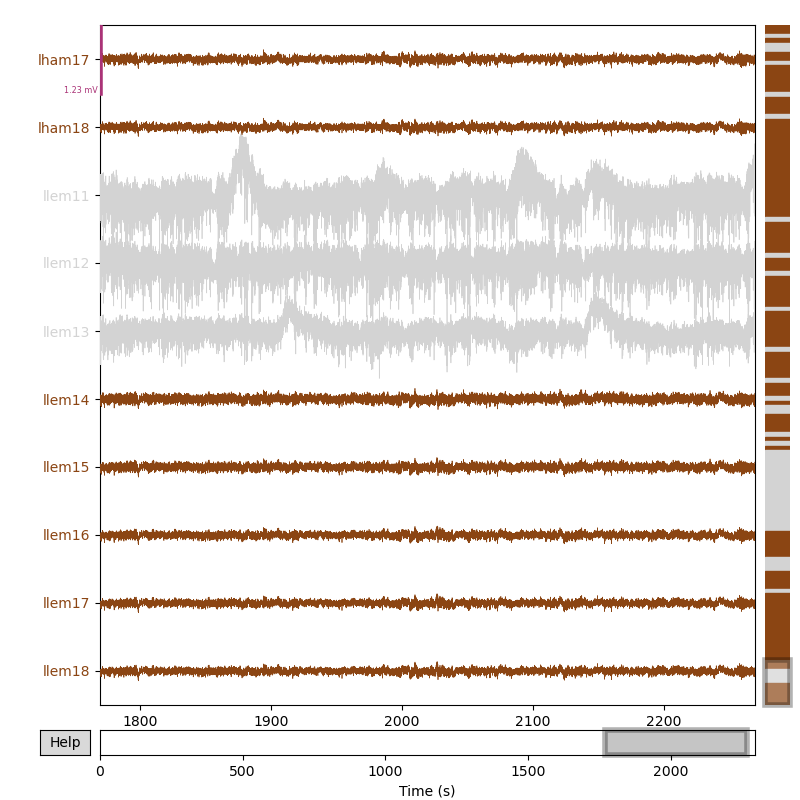

<IPython.core.display.Javascript object>


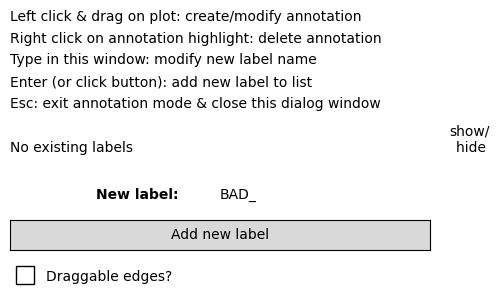

In [65]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [74]:
mne_data.info['bads']

['lacas12',
 'lacas7',
 'laimm15',
 'lham18',
 'lils1_7',
 'llem18',
 'lmcms3',
 'lmcms5',
 'lmcms6',
 'lmls3_3',
 'lmolf3',
 'lmolf5',
 'lmolf6',
 'lmolf9',
 'ragit1',
 'ragit6']

<IPython.core.display.Javascript object>


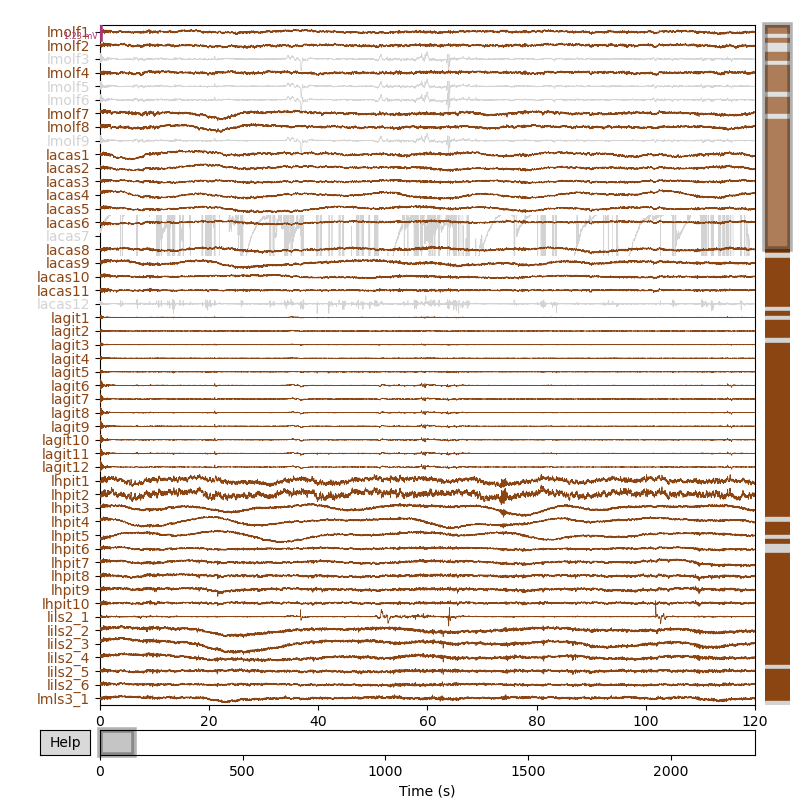

<IPython.core.display.Javascript object>


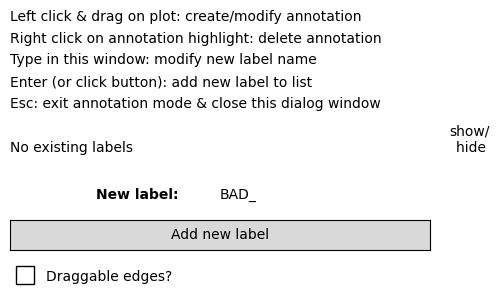

In [72]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [75]:
mne_data.info['bads'] 

['lacas12',
 'lacas7',
 'laimm15',
 'lham18',
 'lils1_7',
 'llem18',
 'lmcms3',
 'lmcms5',
 'lmcms6',
 'lmls3_3',
 'lmolf3',
 'lmolf5',
 'lmolf6',
 'lmolf9',
 'ragit1',
 'ragit6']

In [82]:
#set bad channel info 
ms016_bad_ch = ['lmolf5','lmolf6','lmolf9','lacas7','lacas12','lils2_1','lils1_7','lmls3_7','ragit8','rhpit6','rhpit10','racas2','racas3','racas8','racas10','racas12',
 'laimm1','laimm2','laimm3','laimm4','laimm5','laimm6','laimm7','laimm8','laimm9','laimm10','laimm11','laimm12','laimm13',
'laimm14','laimm15','laimm16','lmcms1','lmcms8','lmcms9','lmcms10','llem11','llem12','llem13','llesma5']

In [83]:
len(ms016_bad_ch)

40

In [84]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = ms016_bad_ch 

In [85]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 40 items (lmolf5, lmolf6, lmolf9, lacas7, lacas12, lils2_1, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 152 sEEG
 custom_ref_applied: False
 dig: 152 items (152 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 12:14:17 UTC
 nchan: 152
 projs: []
 sfreq: 512.0 Hz
>

In [86]:
mne_data.info['bads'] #more sanity checking

['lmolf5',
 'lmolf6',
 'lmolf9',
 'lacas7',
 'lacas12',
 'lils2_1',
 'lils1_7',
 'lmls3_7',
 'ragit8',
 'rhpit6',
 'rhpit10',
 'racas2',
 'racas3',
 'racas8',
 'racas10',
 'racas12',
 'laimm1',
 'laimm2',
 'laimm3',
 'laimm4',
 'laimm5',
 'laimm6',
 'laimm7',
 'laimm8',
 'laimm9',
 'laimm10',
 'laimm11',
 'laimm12',
 'laimm13',
 'laimm14',
 'laimm15',
 'laimm16',
 'lmcms1',
 'lmcms8',
 'lmcms9',
 'lmcms10',
 'llem11',
 'llem12',
 'llem13',
 'llesma5']

### Rereference data to wm electrodes

In [87]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=ms016_anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [88]:
oob_channels

['lacas11',
 'lacas12',
 'lagit11',
 'lagit12',
 'laimm15',
 'laimm16',
 'lils1_7',
 'lils1_8',
 'lmcms10',
 'lmls3_6',
 'lmls3_7',
 'lmls3_8',
 'lmolf9',
 'racas12']

In [89]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
ms016_bad_ch = ms016_bad_ch + oob_channels
ms016_bad_ch = list(np.unique(ms016_bad_ch))
mne_data.info['bads'] = ms016_bad_ch

In [90]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas11',
 'lacas12',
 'lacas7',
 'lagit11',
 'lagit12',
 'laimm1',
 'laimm10',
 'laimm11',
 'laimm12',
 'laimm13',
 'laimm14',
 'laimm15',
 'laimm16',
 'laimm2',
 'laimm3',
 'laimm4',
 'laimm5',
 'laimm6',
 'laimm7',
 'laimm8',
 'laimm9',
 'lils1_7',
 'lils1_8',
 'lils2_1',
 'llem11',
 'llem12',
 'llem13',
 'llesma5',
 'lmcms1',
 'lmcms10',
 'lmcms8',
 'lmcms9',
 'lmls3_6',
 'lmls3_7',
 'lmls3_8',
 'lmolf5',
 'lmolf6',
 'lmolf9',
 'racas10',
 'racas12',
 'racas2',
 'racas3',
 'racas8',
 'ragit8',
 'rhpit10',
 'rhpit6']

In [91]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [92]:
mne_data_reref

<RawEDF | MS016_SWB.edf, 129 x 1175520 (2295.9 s), ~1.13 GB, data loaded>

### Save cleaned continuous data

In [93]:
mne_data.save(f'{neural_dir}/MS016/lfp_data.fif',overwrite=True)

In [94]:
mne_data_reref.save(f'{neural_dir}/MS016/wm_ref_ieeg.fif',overwrite=True)